## 加载库

In [1]:
# -*- coding: utf-8 -*-

import tensorflow as tf
# import tensorflow_addons as tfa # tensorflow2.0以上才能用
import numpy as np
import cv2 # pip install -i https://pypi.tuna.tsinghua.edu.cn/simple/ opencv-python
from imageio import imread, imsave
import scipy.io
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


## 查看风格图片

['styles\\composition_vii.jpg', 'styles\\starry_night.jpg', 'styles\\wave.jpg']
(640, 1024, 3)


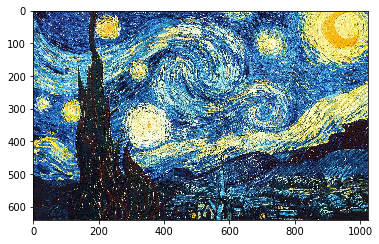

In [2]:
style_images = glob.glob('styles/*.jpg')
print(style_images)
image = imread(style_images[1])
print(image.shape)
plt.imshow(image)

## 加载图格图片

In [3]:

def resize_and_crop(image, image_size):
    h = image.shape[0]
    w = image.shape[1]
    if h > w:
        image = image[h//2 - w//2 : h//2 + w//2, : , :]
    elif h < w:
        image = image[: , w//2 - h//2 : w//2 + h//2, :]
    image = cv2.resize(image, (image_size, image_size))
    return image

X_data = []
image_size = 256
paths = glob.glob('content/train2014/*.jpg')
'''
for i in tqdm(range(len(paths))):
    image = imread(paths[i])
    if len(image.shape) < 3: # 筛掉黑白图片
        continue
    X_data.append(resize_and_crop(image, image_size))
plt.imshow(X_data[-1])
X_data = np.array(X_data)
print(X_data.shape)
np.save('content/train2014_2000.npy', X_data)
'''

"\nfor i in tqdm(range(len(paths))):\n    image = imread(paths[i])\n    if len(image.shape) < 3: # 筛掉黑白图片\n        continue\n    X_data.append(resize_and_crop(image, image_size))\nplt.imshow(X_data[-1])\nX_data = np.array(X_data)\nprint(X_data.shape)\nnp.save('content/train2014_2000.npy', X_data)\n"

In [4]:
X_data = np.load('content/train2014_2000.npy')

In [5]:
print(X_data.shape)

(1989, 256, 256, 3)


# 加载vgg19模型，将模型中的参数设为常量

In [6]:
vgg = scipy.io.loadmat('models/imagenet-vgg-verydeep-19.mat')
vgg_layers = vgg['layers']
print(vgg_layers.shape)
            

(1, 43)


In [7]:
print(vgg_layers[0][1])

[[(array(['relu1_1'], dtype='<U7'), array(['relu'], dtype='<U4'), array([[0]], dtype=uint8), array([], shape=(0, 0), dtype=object), array([[0]], dtype=uint8))]]


In [8]:
def vgg_endpoints(inputs, reuse=None):
    with tf.variable_scope('endpoints', reuse=reuse): #模型中的变量都在变量空间endpoints里
        def _weights(layer, expected_layer_name):
            W = vgg_layers[0][layer][0][0][2][0][0]
            b = vgg_layers[0][layer][0][0][2][0][1]
            layer_name = vgg_layers[0][layer][0][0][0][0]
            assert layer_name == expected_layer_name
            return W, b

        def _conv2d_relu(prev_layer, layer, layer_name):
            W, b = _weights(layer, layer_name)
            W = tf.constant(W)
            b = tf.constant(np.reshape(b, (b.size)))
            return tf.nn.relu(tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b)

        def _avgpool(prev_layer):
            return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        graph = {}
        graph['conv1_1']  = _conv2d_relu(inputs, 0, 'conv1_1')
        graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
        graph['avgpool1'] = _avgpool(graph['conv1_2'])
        graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
        graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
        graph['avgpool2'] = _avgpool(graph['conv2_2'])
        graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
        graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
        graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
        graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
        graph['avgpool3'] = _avgpool(graph['conv3_4'])
        graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
        graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
        graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
        graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
        graph['avgpool4'] = _avgpool(graph['conv4_4'])
        graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
        graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
        graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
        graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
        graph['avgpool5'] = _avgpool(graph['conv5_4'])
        return graph


## 选择一张风格图片，输入vgg19网络中，得到4个风格层的激活值，计算各风格层的Gram矩阵。

In [9]:
style_index = 1
X_style_data = resize_and_crop(imread(style_images[style_index]), image_size)
X_style_data = np.expand_dims(X_style_data, 0)
print(X_style_data.shape)

MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1, 1, 1, 3)) # 通道颜色均值

X_style = tf.placeholder(dtype=tf.float32, shape=X_style_data.shape, name='X_style')
style_endpoints = vgg_endpoints(X_style - MEAN_VALUES)
STYLE_LAYERS = ['conv1_2', 'conv2_2', 'conv3_3', 'conv4_3']
style_features = {}

sess = tf.Session()
for layer_name in STYLE_LAYERS:
    features = sess.run(style_endpoints[layer_name], feed_dict={X_style: X_style_data})
    features = np.reshape(features, (-1, features.shape[3]))
    gram = np.matmul(features.T, features) / features.size
    print(features.shape, gram.shape)
    style_features[layer_name] = gram


(1, 256, 256, 3)
(65536, 64) (64, 64)
(16384, 128) (128, 128)
(4096, 256) (256, 256)
(1024, 512) (512, 512)


## 构造转换网络，为卷积、残差、逆卷积结构

In [11]:
# 这个cell 只需调用一次，重复调用会出错
batch_size = 4
X = tf.placeholder(dtype=tf.float32, shape=[None, None, None, 3], name='X')
k_initializer = tf.truncated_normal_initializer(0, 0.1)

def relu(x):
    return tf.nn.relu(x)

def conv2d(inputs, filters, kernel_size = 3, strides = 1):
    p = int(kernel_size / 2)
    #填充边缘
    h0 = tf.pad(inputs, [[0, 0], [p, p], [p, p], [0, 0]], mode='reflect')
    conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='valid', kernel_initializer=k_initializer)
    return conv(h0)
    #return tf.layers.conv2d(inputs=h0, filters=filters, kernel_size=kernel_size, strides=strides, padding='valid', kernel_initializer=k_initializer)


def deconv2d(inputs, filters, kernel_size = 3, strides = 1):
    shape = tf.shape(inputs)
    height, width = shape[1], shape[2]
    # 近邻插值法，
    h0 = tf.image.resize_images(inputs, [height * strides * 2, width * strides * 2], tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return conv2d(h0, filters, kernel_size, strides)

# 正则化
# Batch_Norm是在一个Batch内不同样本在的标准化，而instance_norm在一个样本内的标准化。
def instance_norm(inputs):
    return tf.contrib.layers.instance_norm(inputs)
    # return tfa.layers.InstanceNormalization(inputs)
# 残差网络
def residual(inputs, filters = 128, kernel_size = 3):
    h0 = relu(conv2d(inputs, filters, kernel_size, 1))
    h0 = conv2d(h0, filters, kernel_size, 1)
    print('############################################',h0)
    return tf.add(inputs, h0)

with tf.variable_scope('transformer', reuse=None):
    h0 = tf.pad(X - MEAN_VALUES, [[0, 0], [10, 10], [10, 10], [0, 0]], mode='reflect')
    #print(conv2d(h0, 32, 9, 1))
    h0 = relu(instance_norm(conv2d(h0, 32, 9, 1)))
    h0 = relu(instance_norm(conv2d(h0, 64, 3, 2)))
    h0 = relu(instance_norm(conv2d(h0, 128, 3, 2)))

    for i in range(5):
        h0 = residual(h0, 128, 3)

    h0 = relu(instance_norm(deconv2d(h0, 64, 3, 2)))
    h0 = relu(instance_norm(deconv2d(h0, 32, 3, 2)))
    h0 = tf.nn.tanh(instance_norm(conv2d(h0, 3, 9, 1)))
    h0 = (h0 + 1) / 2 * 255.
    shape = tf.shape(h0)
    g = tf.slice(h0, [0, 10, 10, 0], [-1, shape[1] - 20, shape[2] - 20, -1], name='g')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

############################################ Tensor("transformer_1/conv2d_4/BiasAdd:0", shape=(?, ?, ?, 128), dtype=float32)
############################################ Tensor("transformer_1/conv2d_6/BiasAdd:0", shape=(?, ?, ?, 128), dtype=float32)
############################################ Tensor("transformer_1/conv2d_8/BiasAdd:0", shape=(?, ?, ?, 128), dtype=float32)
############################################ Tensor("transformer_1/conv2d_10/BiasAdd:0", shape=(?, ?, ?, 128), dtype=float32)
############################################ Tensor("t

## 将迁移图片和原始图片输入到 vgg19，得到各自对应输出
### 计算内容损失


In [12]:
CONTENT_LAYER = 'conv3_3'
content_endpoints = vgg_endpoints(X - MEAN_VALUES, True)
g_endpoints = vgg_endpoints(g - MEAN_VALUES, True)

def get_content_loss(endpoints_x, endpoints_y, layer_name):
    x = endpoints_x[layer_name]
    y = endpoints_y[layer_name]
    return 2 * tf.nn.l2_loss(x-y) / tf.to_float(tf.size(x))

content_loss = get_content_loss(content_endpoints, g_endpoints, CONTENT_LAYER)

Instructions for updating:
Use `tf.cast` instead.


## 计算风格损失

In [15]:
style_loss = []
for layer_name in STYLE_LAYERS:
    layer = g_endpoints[layer_name]
    shape = tf.shape(layer)
    bs, height, width, channel = shape[0], shape[1], shape[2], shape[3]
    
    features = tf.reshape(layer, (bs, height * width, channel))
    gram = tf.matmul(tf.transpose(features, (0,2,1)), features) / tf.to_float(height * width * channel)
    
    style_gram = style_features[layer_name]
    style_loss.append(2 * tf.nn.l2_loss(gram - style_gram) / tf.to_float(tf.size(layer)))
    
style_loss = tf.reduce_sum(style_loss)

## 计算全变差正则， 得到总损失函数

In [17]:
def get_total_variation_loss(inputs):
    h = inputs[:, :-1, :, :] - inputs[:, 1:, :, :]
    w = inputs[:, :, 1:, :]
    return tf.nn.l2_loss(h) / tf.to_float(tf.size(h)) + tf.nn.l2_loss(w) / tf.to_float(tf.size(w))

total_variation_loss = get_total_variation_loss(g)

content_weight = 1
style_weight = 250
total_variation_weight = 0.01
loss = content_weight * content_loss + style_weight * style_loss + total_variation_weight * total_variation_loss


## 定义优化器

In [18]:
vars_t = [var for var in tf.trainable_variables() if var.name.startswith('transformer')]
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss, var_list=vars_t)

## 训练模型

In [ ]:
style_name = style_images[style_index]
style_name = style_name[style_name.find('/') + 1:].rstrip('.jpg')
OUTPUT_DIR = 'samples_%s' % style_name
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

tf.summary.scalar('losses/content_loss', content_loss)
tf.summary.scalar('losses/style_loss', style_loss)
tf.summary.scalar('losses/total_variation_loss', total_variation_loss)
tf.summary.scalar('losses/loss', loss)
tf.summary.scalar('weighted_losses/weighted_content_loss', content_weight * content_loss)
tf.summary.scalar('weighted_losses/weighted_style_loss', style_weight * style_loss)
tf.summary.scalar('weighted_losses/weighted_total_variation_loss', total_variation_weight * total_variation_loss)
tf.summary.image('transformed', g)
tf.summary.image('origin', X)
summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(OUTPUT_DIR)

sess.run(tf.global_variables_initializer())
losses = []
epochs = 2

X_sample = imread('content/0.jpg')
h_sample = X_sample.shape[0]
w_sample = X_sample.shape[1]

for e in range(epochs):
    data_index = np.arange(X_data.shape[0])
    np.random.shuffle(data_index)
    X_data = X_data[data_index]
    
    for i in tqdm(range(X_data.shape[0] // batch_size)):
        X_batch = X_data[i * batch_size: i * batch_size + batch_size]
        ls_, _ = sess.run([loss, optimizer], feed_dict={X: X_batch})
        losses.append(ls_)
        
        if i > 0 and i % 20 == 0:
            writer.add_summary(sess.run(summary, feed_dict={X: X_batch}), e * X_data.shape[0] // batch_size + i)
            writer.flush()
        
    print('Epoch %d Loss %f' % (e, np.mean(losses)))
    losses = []

    gen_img = sess.run(g, feed_dict={X: [X_sample]})[0]
    gen_img = np.clip(gen_img, 0, 255)
    result = np.zeros((h_sample, w_sample * 2, 3))
    result[:, :w_sample, :] = X_sample / 255.
    result[:, w_sample:, :] = gen_img[:h_sample, :w_sample, :] / 255.
    plt.axis('off')
    plt.imshow(result)
    plt.show()
    imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % e), result)


  1%|▊                                                                               | 5/497 [02:22<3:55:22, 28.70s/it]

## 保存模型

In [ ]:
saver = tf.train.Saver()
saver.save(sess, os.path.join(OUTPUT_DIR, 'fast_style_transfer'))

In [18]:
style_name

'styles\\starry_night'